<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">
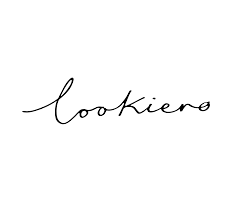    


---
<h3>Beñat Basabe, Jon Jarrín, June Pagaldai, Daniel Puente, Eneko Rentería | <font color='red'> Equipo Rojo<h3>

## Estadísticas de los grafos y looks
Se extraen todas las características de los grafos ya generados

### Carga de librerias 
---

- **General**

In [1]:
import pandas as pd
import numpy as np
import pickle

def guardar_pikle(df, name):
    with open(dir_out + str(name) + '.pkl', 'wb') as fp: pickle.dump(df, fp)

def abrir_pikle(name):
    with open(dir_out + str(name) + '.pkl', 'rb') as fp: df = pickle.load(fp)
    return df

In [2]:
import warnings
warnings.filterwarnings('ignore')

- **Pyspark**

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.functions import col
from pyspark.sql.functions import when

- **Strings**

In [4]:
from collections import Counter

- **Visualización**

In [ ]:
import matplotlib.pyplot as plt

* **Grafos**

In [ ]:
import networkx as nx

- **Otros**

In [ ]:
import itertools

## Funciones a utilizar
---

In [ ]:
dir_in, dir_out = "../../datos/datos_originales/", "../../datos/datos_desarrollo/"

spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

- Función para **dar nombre** a la variable **family_id** mediante la variable title

In [ ]:
def get_family_name(id_):
    
    filtered = product.filter(product.family_id == id_)
    string = ' '.join([x['title'] for x in filtered.select('title').collect()]).lower()
    
    return id_, Counter(string.split()).most_common(1)[0][0]

- Función para crear los **sufijos** y facilitar el *join*

In [ ]:
def rename_columns(df, suffix):
    ''' Renombra las columnas de un dataframe.'''
    for names in df.schema.names: df = df.withColumnRenamed(names,names + suffix)
    return df

* Función para conseguir valores únicos de una variable en *pyspark*

In [ ]:
def get_value(dffs, variable):
    return list(dffs.select(dffs[variable]).distinct().toPandas()[variable])

### Cargar datos
---

In [ ]:
df = spark.read.csv(dir_out + 'lookiero_*.csv', header=True, inferSchema=True)
df_total = spark.read.csv(dir_out + 'df_total.csv', header=True, inferSchema=True)
df_indices = pd.DataFrame(get_value(df, 'id_product'))

In [ ]:
embarazadas = get_value(df.filter((df.value == "pregnancy") | (df.value == "breastfeeding")), 'id_product')
df = df.withColumn("level",col("level").cast(StringType()))
df = df.withColumn("pregnant", when(df.id_product.isin(embarazadas),1).otherwise(0))

In [ ]:
df.show(5)

+--------------------+------+-----+-----------+-------------+-----+------------------+--------------+----------+-------------+-----+------------+---------------+--------------------+------------------+-----+--------+
|                  id|season|stock|publishable|size_lookiero|color|        id_product|family_product|name_brand| origin_brand|value|name_feature|multiple_values|      feature_family|id_product_feature|level|pregnant|
+--------------------+------+-----+-----------+-------------+-----+------------------+--------------+----------+-------------+-----+------------+---------------+--------------------+------------------+-----+--------+
|498662e5-11e8-483...|     8|    0|       true|            M| ecru| cardigan_ecru_M_8|      cardigan|  BRAND112|NO_MAINSTREAM|   55| hip_contour|          false|c6b81db8-29ed-43d...|    hip_contour_55|  2.2|       0|
|dcda2fe4-58e3-4b2...|     8|    0|       true|            S| ecru| cardigan_ecru_S_8|      cardigan|  BRAND112|NO_MAINSTREAM|   55|

#### Similutud entre grafos
---

In [ ]:
from grakel.kernels import ShortestPath, WeisfeilerLehman, GraphletSampling, RandomWalk
from grakel.datasets import fetch_dataset
import networkx as nx
import pickle
import grakel

In [ ]:
dir_in, dir_out = "../../datos/datos_originales/", "../../datos/datos_desarrollo/"
def guardar_pikle(df, name):
    with open(dir_out + str(name) + '.pkl', 'wb') as fp: pickle.dump(df, fp)

def abrir_pikle(name):
    with open(dir_out + str(name) + '.pkl', 'rb') as fp: df = pickle.load(fp)
    return df
    
MUTAG = fetch_dataset ("MUTAG", verbose = False )
G , y = MUTAG.data , MUTAG.target

* Graphs

In [ ]:
G7, G8, G9 = abrir_pikle('G7'), abrir_pikle('G8'), abrir_pikle('G9')

* Models

In [ ]:
modelWeisfeiler, modelShortest, modelGraphlet = WeisfeilerLehman(), ShortestPath(), GraphletSampling()

Note also that GraKeL contains implementations of kernels between graphs (i.e., kernels that compare graphs to each other). Therefore, feeding a single graph to the fit_transform() function will just produce a single number (i.e., the kernel value between the input graph and itself). Furthermore, the shortest path kernel expects the input graphs to contain node labels. If they do not, you should set the parameter with_labels=False.

In [ ]:
for x in ['level','color', 'size']:
    Grakel = grakel.graph_from_networkx([G7, G8, G9], node_labels_tag=x, edge_labels_tag='weight')
    display(modelWeisfeiler.fit_transform(Grakel))

array([[5687586., 3525461., 4187966.],
       [3525461., 4562004., 3684795.],
       [4187966., 3684795., 6146298.]])

array([[1104898.,  800312.,  878110.],
       [ 800312.,  795222.,  731992.],
       [ 878110.,  731992.,  935046.]])

array([[1396100., 1191908., 1338701.],
       [1191908., 1292412., 1288788.],
       [1338701., 1288788., 1638196.]])

* Estos modelos tardan muchisimo

In [ ]:
A = nx.adjacency_matrix(G7)

def select_k(spectrum, minimum_energy = 0.5):
    running_total = 0.0
    total = sum(spectrum)
    if total == 0.0:
        return len(spectrum)
    for i in range(len(spectrum)):
        running_total += spectrum[i]
        if running_total / total >= minimum_energy:
            return i + 1
    return len(spectrum)

for x in [[G7, G8], [G7, G9], [G8, G9]]:
    laplacian1 = nx.spectrum.laplacian_spectrum(x[0])
    laplacian2 = nx.spectrum.laplacian_spectrum(x[1])

    k1 = select_k(laplacian1)
    k2 = select_k(laplacian2)
    k = min(k1, k2)

    similarity = sum((laplacian1[:k] - laplacian2[:k])**2)
    print(f'Similarity of {x[0].name} and {x[1].name}: {similarity}')

Similarity of G7 and G8: 6059508.999999985
Similarity of G7 and G9: 2912325.999999974
Similarity of G8 and G9: 5538741.999999972


* Se han empleado otros métodos de similitud entre grafos, pero dado la longitud de los grafos resultan muy costosos   

<center> 
<img  src="../imagenes/networkx_similarity.PNG" height = 500> 


### Graph statitiscs


* Estadísticas básicas

In [ ]:
variables = []
for x in [G7, G8, G9]:
    nodos = x.number_of_nodes()
    aristas = x.number_of_edges()
    grados_medio = (x.number_of_edges() / x.number_of_nodes()) * 2
    isolated = len([n for n, d in x.degree() if d == 0])

    closeness = nx.closeness_centrality(x, wf_improved=False)
    closeness_mean = np.array(list(closeness.values())).mean()
    variables.append([nodos, aristas, grados_medio, isolated, closeness_mean])

pd.DataFrame(variables, columns = ['nodos', 'aristas', 'grado_medio', 'isolated', 'closeness_mean'])

,nodos,aristas,grado_medio,isolated,closeness_mean
0,2079,116052,111.642136,1342,0.228668
1,1870,53935,57.684492,1286,0.190561
2,2185,125528,114.899771,1396,0.230245


* Commmon neighbors (cogemos los pares de nodos que no están conectados)

In [ ]:
targets = nx.non_edges(G7)
common_neighbors = [(e[0], e[1], len(list(nx.common_neighbors(G7, e[0], e[1])))) for e in targets]
common_neighbors = sorted(common_neighbors, key=lambda x: x[2], reverse=True)

# Los 2 primeros valores son los nodos, mientras que el tercero es la cantidad de vecinos similares
common_neighbors[:10]

[(22, 24, 509),
 (22, 27, 509),
 (22, 44, 509),
 (22, 46, 509),
 (22, 47, 509),
 (22, 51, 509),
 (22, 53, 509),
 (22, 56, 509),
 (22, 62, 509),
 (22, 70, 509)]

* Jaccard coefficient. It normalizes the union of the two nodes

In [ ]:
jaccard_coefficients = list(nx.jaccard_coefficient(G7))
jaccard_coefficients = sorted(jaccard_coefficients, key=lambda x: x[2], reverse=True)
jaccard_coefficients[:10]

[(1, 19, 1.0),
 (1, 23, 1.0),
 (1, 28, 1.0),
 (1, 32, 1.0),
 (1, 35, 1.0),
 (1, 38, 1.0),
 (1, 41, 1.0),
 (1, 54, 1.0),
 (1, 58, 1.0),
 (1, 59, 1.0)]

* Resource allocation

In [ ]:
resource_allocation = list(nx.resource_allocation_index(G7))
resource_allocation = sorted(resource_allocation, key=lambda x: x[2], reverse=True)
resource_allocation[:10]

[(22, 24, 2.2324561403508643),
 (22, 27, 2.2324561403508643),
 (22, 44, 2.2324561403508643),
 (22, 46, 2.2324561403508643),
 (22, 47, 2.2324561403508643),
 (22, 51, 2.2324561403508643),
 (22, 53, 2.2324561403508643),
 (22, 56, 2.2324561403508643),
 (22, 62, 2.2324561403508643),
 (22, 70, 2.2324561403508643)]

* Adamic-Adar index

In [ ]:
adamic_adar_index = list(nx.adamic_adar_index(G7))
adamic_adar_index = sorted(adamic_adar_index, key=lambda x: x[2], reverse=True)
adamic_adar_index[:10]

[(22, 24, 93.74978768813759),
 (22, 27, 93.74978768813759),
 (22, 44, 93.74978768813759),
 (22, 46, 93.74978768813759),
 (22, 47, 93.74978768813759),
 (22, 51, 93.74978768813759),
 (22, 53, 93.74978768813759),
 (22, 56, 93.74978768813759),
 (22, 62, 93.74978768813759),
 (22, 70, 93.74978768813759)]